### CLIP Feature Extraction

In [5]:
# Import Libraries

# General
import gc
import os
import random
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Matrix Manipulation
import numpy as np
import pandas as pd

# Image Handling
from torchvision.transforms import transforms
from torchvision import transforms, datasets

# Dataset
import huggingface_hub
from datasets import load_dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


# Model Building
import clip
import torch
from torch import nn
import torch.optim as optim

# Random Seed
np.random.seed(0)

/Users/braydendiu/.pyenv/versions/3.10.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# # HuggingFace Login to access the data
# huggingface_hub.notebook_login()

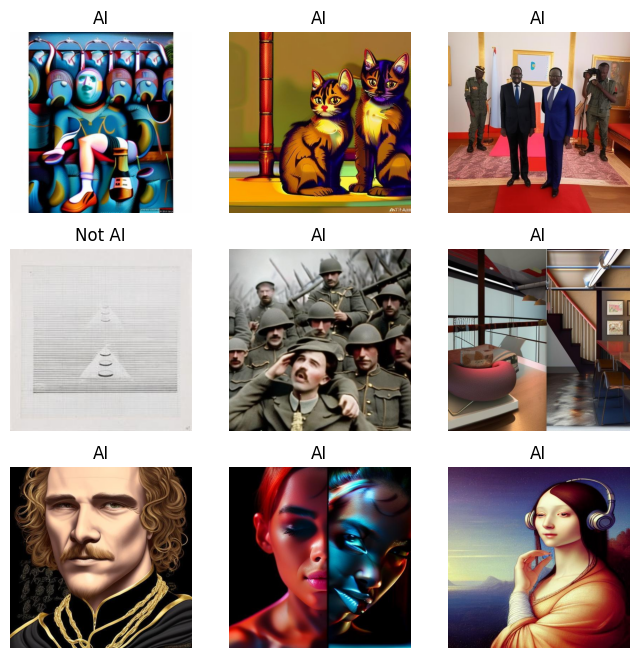

100%|██████████| 37/37 [1:24:38<00:00, 137.26s/it]


In [7]:
# Load Train Data
dataset = load_dataset('competitions/aiornot', split='train')

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    _, img, label = dataset[sample_idx].values()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# DataLoader to load data
BATCH_SIZE = 512

# Loading CLIP Model to extract features from the images
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
model.eval()

def collate_fn(data):
  return torch.stack([preprocess(x['image']) for x in data]), torch.tensor([x['label'] for x in data])
  
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# For Storing Extracted Features
image_features = list()
labels = list()

# Folder to save all extrated features
if not os.path.exists('Fatima-Fellowship-Challenge'):
  os.mkdir('Fatima-Fellowship-Challenge')
  os.mkdir('Fatima-Fellowship-Challenge/output')
  os.mkdir('Fatima-Fellowship-Challenge/label')
else:
  if not os.path.exists('Fatima-Fellowship-Challenge/output-clip'):
    os.mkdir('Fatima-Fellowship-Challenge/output-clip')
    os.mkdir('Fatima-Fellowship-Challenge/label-clip')


# Frees up GPU, when running inference in a loop, to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  if torch.cuda.is_available():
    # Reset Already occupied Memory and Cache
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    torch.cuda.empty_cache()

  # Garbage Collection (good even for CPU)
  gc.collect()

# Extract Features
idx = 0
for batch, label in tqdm(dataloader):
  
  # Moving the batch image tensor to cuda
  batch = batch.to(device)
  
  # CLIP Feature Extraction
  with torch.no_grad():
    output = model.encode_image(batch)
  
  # Saving Features
  torch.save(output, f'Fatima-Fellowship-Challenge/output-clip/{idx}.pt')
  torch.save(label, f'Fatima-Fellowship-Challenge/label-clip/{idx}.pt')
  idx += 1

  optimize_gpu()

# image_features = torch.concatenate(image_features)
# labels = torch.concatenate(labels)

In [18]:
with torch.no_grad():
    val_inputs, val_labels = next(iter(valloader))
    val_inputs = val_inputs.float()
    pred_probs = classifier(val_inputs)
    preds = torch.argmax(pred_probs, dim=1)

In [19]:
image_features = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/output-clip/{i}.pt' for i in range(37)]]
image_labels = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/label-clip/{i}.pt' for i in range(37)]]

In [20]:
image_features = torch.concatenate(image_features)
image_labels = torch.concatenate(image_labels)

In [21]:
BATCH_SIZE = 32
VAL_SIZE = 1000
traindataset = TensorDataset(image_features[:-VAL_SIZE], image_labels[:-VAL_SIZE])
trainloader = DataLoader(traindataset, BATCH_SIZE, True)
valdataset = TensorDataset(image_features[-VAL_SIZE:], image_labels[-VAL_SIZE:])
valloader = DataLoader(valdataset, 1000)

In [22]:
classifier = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
#classifier = classifier.cuda()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=0.9)

In [ ]:
NUM_EPOCHS = 150
train_loss = list()
val_loss = list()

for epoch in range(NUM_EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        inputs, labels = data

        # REMOVE .cuda()
        inputs = inputs.float()
        labels = labels

        optimizer.zero_grad()

        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            with torch.no_grad():
                inps, labs = next(iter(valloader))
                inps = inps.float()  
                labs = labs          
                out = classifier(inps)
                val_los = criterion(out, labs).item()

            train_loss.append(running_loss)
            val_loss.append(val_los)

            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss:.3f} | val_loss: {val_los:.3f}')
            running_loss = 0.0

print('Finished Training')
accuracy = (preds == next(iter(valloader))[1]).sum().item() / len(valdataset)
print(f"\n Final Validation Accuracy: {accuracy:.4f}")

[1,   100] train_loss: 45.910 | val_loss: 0.319
[1,   200] train_loss: 28.168 | val_loss: 0.253
[1,   300] train_loss: 23.420 | val_loss: 0.217
[1,   400] train_loss: 21.324 | val_loss: 0.195
[1,   500] train_loss: 20.947 | val_loss: 0.183
[2,   100] train_loss: 18.073 | val_loss: 0.171
[2,   200] train_loss: 17.711 | val_loss: 0.164
[2,   300] train_loss: 16.670 | val_loss: 0.159
[2,   400] train_loss: 15.176 | val_loss: 0.156
[2,   500] train_loss: 14.821 | val_loss: 0.155
[3,   100] train_loss: 13.937 | val_loss: 0.153
[3,   200] train_loss: 14.727 | val_loss: 0.149
[3,   300] train_loss: 13.475 | val_loss: 0.147
[3,   400] train_loss: 15.462 | val_loss: 0.143
[3,   500] train_loss: 14.955 | val_loss: 0.142
[4,   100] train_loss: 13.607 | val_loss: 0.143
[4,   200] train_loss: 12.817 | val_loss: 0.143
[4,   300] train_loss: 14.690 | val_loss: 0.142
[4,   400] train_loss: 14.183 | val_loss: 0.143
[4,   500] train_loss: 13.451 | val_loss: 0.139
[5,   100] train_loss: 13.030 | val_loss

In [ ]:
# Get predictions on validation set
with torch.no_grad():
    val_imgs, val_labels = next(iter(valloader))
    val_imgs = val_imgs.float()
    outputs = classifier(val_imgs)
    preds = torch.argmax(outputs, dim=1)

misclassified = (preds != val_labels).nonzero(as_tuple=True)[0]
val_data = list(dataset)[-len(val_labels):]  


In [ ]:
!pip install -q lime

from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# models in eval mode
model.eval()
classifier.eval()

# wrapper for clip + classifier
def predict_fn(images_np):
    images_tensor = torch.stack([
        preprocess(Image.fromarray(img).convert("RGB")).to(device)
        for img in images_np
    ])
    with torch.no_grad():
        features = model.encode_image(images_tensor)
        outputs = classifier(features).cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(outputs), dim=1).numpy()
    return probs

# choose sample image (misclassified or not)
sample_idx = misclassified[random.randint(0, len(misclassified) - 1)]
img_pil = val_data[sample_idx]['image'].convert("RGB")
img_np = np.array(img_pil)

# run lime
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# visualize top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Pixel Importance Heatmap")
plt.axis("off")
plt.show()


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


 47%|████▋     | 469/1000 [01:46<02:00,  4.41it/s]


KeyboardInterrupt: 

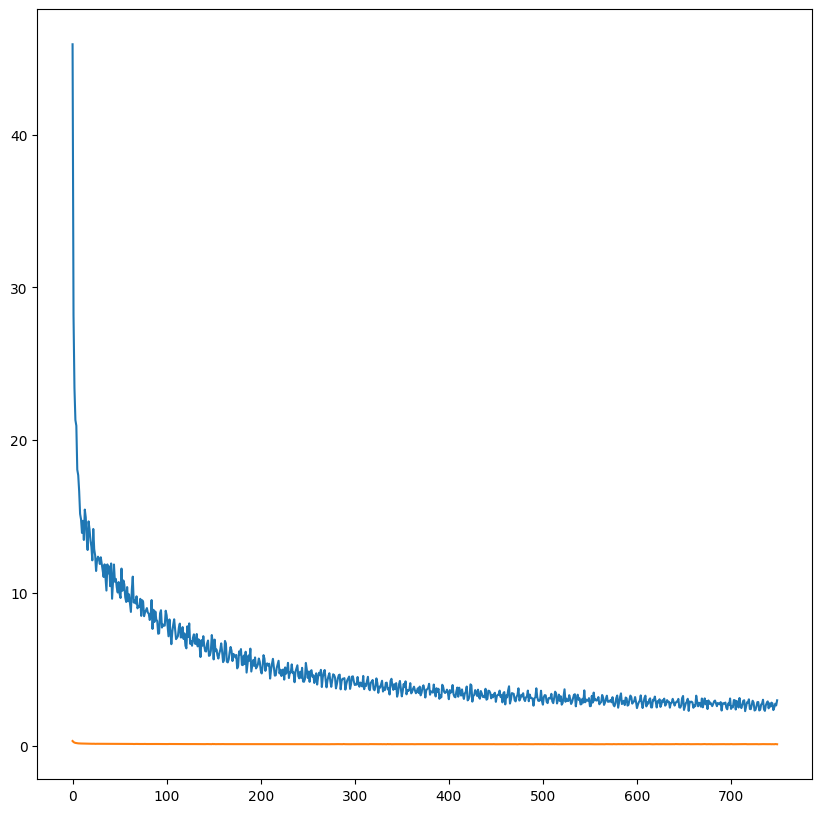

In [26]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class AiArtFlatFolderDataset(Dataset):
    def __init__(self, folder_path, preprocess):
        self.preprocess = preprocess
        self.image_paths = []
        self.labels = []

        for fname in os.listdir(folder_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                label = 1 if "ai" in fname.lower() else 0  
                self.image_paths.append(os.path.join(folder_path, fname))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.preprocess(image)
        label = self.labels[idx]
        return image, label

In [28]:
aiart_dataset = AiArtFlatFolderDataset("./AiArtData", preprocess=preprocess)
aiart_loader = DataLoader(aiart_dataset, batch_size=64, shuffle=False)

In [ ]:
model.eval()
classifier.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in aiart_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        features = model.encode_image(imgs)
        outputs = classifier(features)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f" Accuracy on AiArtData: {accuracy:.4f}")

/Users/braydendiu/.pyenv/versions/3.10.1/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Accuracy on AiArtData: 0.4496


In [30]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels, 
    all_preds, 
    target_names=["Real", "AI"], 
    digits=2
))

              precision    recall  f1-score   support

        Real       0.69      0.16      0.26       324
          AI       0.41      0.89      0.56       212

    accuracy                           0.45       536
   macro avg       0.55      0.53      0.41       536
weighted avg       0.58      0.45      0.38       536



In [52]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

combined_dataset = ImageFolder(
    root="./KaggleData",  # root directory contains AiArtData/ and RealArt/
    transform=preprocess  # CLIP preprocessing
)

combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)

# See class mapping
print("Class indices:", combined_dataset.class_to_idx)

Class indices: {'AiArtData': 0, 'RealArt': 1}


In [53]:
model.eval()
classifier.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in combined_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        features = model.encode_image(imgs)
        outputs = classifier(features)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

/Users/braydendiu/.pyenv/versions/3.10.1/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [54]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=combined_dataset.classes,  # Automatically picks AiArtData / RealArt
    digits=2
))

              precision    recall  f1-score   support

   AiArtData       0.36      0.14      0.20       539
     RealArt       0.39      0.69      0.50       434

    accuracy                           0.38       973
   macro avg       0.37      0.41      0.35       973
weighted avg       0.37      0.38      0.33       973



In [55]:
# GET 4 LISTS
# Ensure model is in eval mode
model.eval()
classifier.eval()

# Initialize storage
ai_correct = []
ai_wrong = []
real_correct = []
real_wrong = []

# Class index map
class_map = combined_dataset.class_to_idx  # e.g., {'AiArtData': 0, 'RealArt': 1} or reverse
idx_to_class = {v: k for k, v in class_map.items()}

# Loop through dataset with paths
for i in range(len(combined_dataset)):
    img, label = combined_dataset[i]
    img_path, _ = combined_dataset.samples[i]  # path to the image

    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        features = model.encode_image(img_tensor)
        output = classifier(features)
        pred = torch.argmax(output, dim=1).item()

    # Classify based on prediction vs label
    true_class = idx_to_class[label]
    pred_class = idx_to_class[pred]

    if true_class == "AiArtData":
        if pred_class == "AiArtData":
            ai_correct.append(img_path)
        else:
            ai_wrong.append(img_path)
    else:
        if pred_class == "RealArt":
            real_correct.append(img_path)
        else:
            real_wrong.append(img_path)


/Users/braydendiu/.pyenv/versions/3.10.1/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [56]:
# GET 4 LISTS
def save_list_to_txt(lst, filename):
    with open(filename, "w") as f:
        for path in lst:
            f.write(f"{path}\n")

save_list_to_txt(ai_correct, "ai_correctly_classified.txt")
save_list_to_txt(ai_wrong, "ai_misclassified_as_natural.txt")
save_list_to_txt(real_wrong, "natural_misclassified_as_ai.txt")
save_list_to_txt(real_correct, "natural_correctly_classified.txt")


In [42]:
# SALIENCY MAP

from captum.attr import Saliency
import torch.nn.functional as F

class FullModelWrapper(torch.nn.Module):
    def __init__(self, clip_model, classifier):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = classifier

    def forward(self, x):
        features = self.clip_model.encode_image(x)
        out = self.classifier(features)
        return out

full_model = FullModelWrapper(model, classifier).eval()


In [ ]:
# SALIENCY MAP

import os
from PIL import Image

# Reload AiArtData images + labels
aiart_dataset = AiArtFlatFolderDataset("./AiArtData", preprocess=preprocess)

# Iterate to find first correctly predicted AI image
correct_idx = None
for i in range(len(aiart_dataset)):
    img, label = aiart_dataset[i]
    if label != 1:  # skip real images
        continue
    with torch.no_grad():
        img_batch = img.unsqueeze(0).to(device)
        features = model.encode_image(img_batch)
        output = classifier(features)
        pred = torch.argmax(output, dim=1).item()
        if pred == 1:
            correct_idx = i
            break

if correct_idx is None:
    raise ValueError("No correctly classified AI image found.")

# Load unprocessed original image
image_path = "image path here"
raw_img = Image.open(image_path).convert("RGB")

# Preprocessed version for saliency
input_tensor = preprocess(raw_img).unsqueeze(0).to(device).requires_grad_()


In [44]:
# SALIENCY MAP

from captum.attr import NoiseTunnel, Saliency

saliency = Saliency(full_model)
smooth = NoiseTunnel(saliency)

attributions = smooth.attribute(
    input_tensor,
    nt_type='smoothgrad',
    stdevs=0.2,
    nt_samples=25,
    target=1  # target class: AI
)

# Average over RGB channels
saliency_map = attributions.squeeze().cpu().detach().numpy()
saliency_map = np.abs(saliency_map).mean(axis=0)


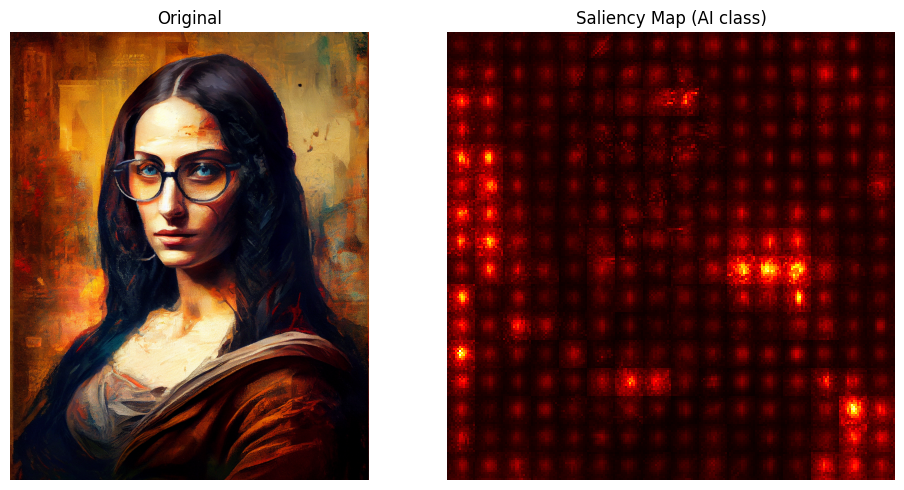

In [45]:
# SALIENCY MAP

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(raw_img)
plt.title("Original")
plt.axis("off")

# Saliency heatmap
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title("Saliency Map (AI class)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
with torch.no_grad():
  pred_probs = classifier(next(iter(valloader))[0].float())

In [36]:
preds = np.argmax(pred_probs.cpu(), 1)

In [37]:
torch.sum(preds == next(iter(valloader))[1].cpu()) / len(valdataset)

tensor(0.9540)

In [38]:
misclassified = list(((preds != next(iter(valloader))[1].cpu())).nonzero().squeeze().numpy())

In [55]:
val_data = list(dataset)[-VAL_SIZE:]


In [56]:
random.randint(0, len(misclassified))

12

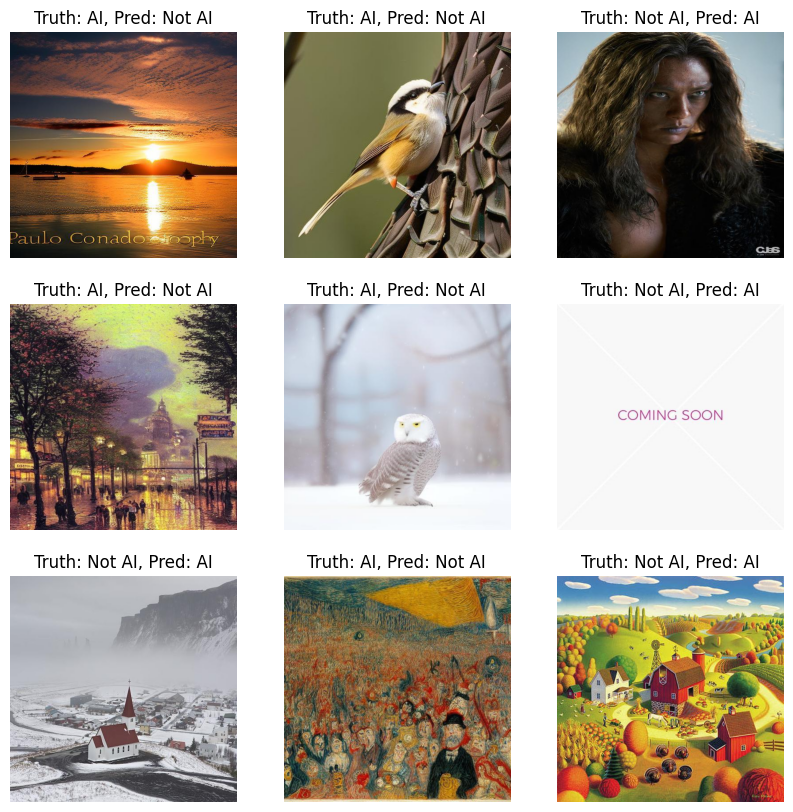

In [ ]:
# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = misclassified[random.randint(0, len(misclassified))]
    img, label = val_data['image'][sample_idx], val_data['label'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Truth: {labels_map[label]}, Pred: {labels_map[list(preds.numpy())[sample_idx]]}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()